# Boston house price

In [ ]:
# 預防錯誤： OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [1]:
# Loading boston housing dataset
# shape of training and testing dataset: (404, 13) (102, 13)
# train_targets and test_targets are us dollars in thousand $

from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
# normalize data, 做法是減去平均值後除以標準差

# 對每一欄求平均,所得是shape=(13,)的ndarray
mean = train_data.mean(axis=0) 
train_data -= mean 
# 對每一欄求標準差,所得是shape=(13,)的ndarray
std = train_data.std(axis=0) 
train_data /= std

# 這是之前最大的疑問,testing set要用自己或訓練集的mean、std來做標準化
test_data -= mean 
test_data /= std

In [3]:
# build the network

from keras import models 
from keras import layers

# 因為是做線性迴歸,所以輸出層只放一個沒有activation function的神經元,並以MSE做損失函數
def build_model():
    model = models.Sequential() 
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],))) 
    model.add(layers.Dense(64, activation='relu')) 
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [4]:
# 在樣本量這麼少的情況下，使用K-fold驗證
import numpy as np

k = 4 
num_val_samples = len(train_data) // k 
num_epochs = 500 
all_mae_histories = []

for i in range(k):
    print('processing fold #', i) 
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate( [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0) 
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model() 
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0) 
    mae_history = history.history['val_mean_absolute_error'] 
    all_mae_histories.append(mae_history)


processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


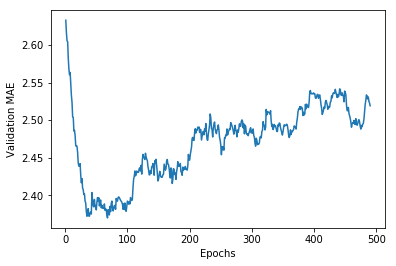

In [9]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

def smooth_curve(points, factor=0.9):
    smoothed_points = [] 
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1] 
            smoothed_points.append(previous * factor + point * (1 - factor)) 
        else:
            smoothed_points.append(point) 
    return smoothed_points

# 排除數值較高的前十筆，餘做平滑化後才繪成圖型
smooth_mae_history = smooth_curve(average_mae_history[10:])

import matplotlib.pyplot as plt

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE') 
plt.show()

In [ ]:
# 根據圖型顯示，第80個epoch後已無法有效降低MAE，訓練最終模型

model = build_model() 
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)